This script follows [the standard CIFAR10 Pytorch example](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). It extracts a single "channel" from the HTRU1 dataset and treats it as a greyscale image.

The steps are:

1. Load and normalizing the HTRU1 training and test datasets using torchvision
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

First import some standard python libraries for plotting stuff and handling arrays:

In [1]:
import matplotlib.pyplot as plt
import numpy as np

Then import the pytorch and torchvision libraries:

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

Then import the pytorch neural network stuff:

In [3]:
import torch.nn as nn
import torch.nn.functional as F

Then import the oprimization library from pytorch:

In [4]:
import torch.optim as optim

Finally import the HTRU1 pytorch dataset class. This is not provided with pytorch, you need to [grab it from the HTRU1 github](
https://raw.githubusercontent.com/as595/HTRU1/master/htru1.py).

In [5]:
from htru1 import HTRU1

Define a torchvision transform to extract a single channel from the multi-channel dataset:

In [6]:
def select_channel(x,c):
    
    from PIL import Image
    
    np_img = np.array(x, dtype=np.uint8)
    ch_img = np_img[:,:,c]
    img = Image.fromarray(ch_img, 'L')
    
    return img

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1]. The first transform extracts Channel 0 (DM surface) from the data.

In [7]:
transform = transforms.Compose(
    [transforms.Lambda(lambda x: select_channel(x,0)),
     transforms.ToTensor(),
     transforms.Normalize([0.5],[0.5])])

Load in the training and test datasets. The first time you do this it will download the data to your working directory, but once the data is there it will just use it without repeating the download.

In [8]:
trainset = HTRU1(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

0it [00:00, ?it/s]

183099392it [01:20, 2759732.06it/s]                               

In [9]:
testset = HTRU1(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

Files already downloaded and verified


There are two classes in this dataset: pulsar and nonpulsar (i.e. RFI):

In [10]:
classes = ('pulsar', 'nonpulsar')

A little function to display images nicely:

In [11]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Take a look at some randomly selected samples to see how they appear:

In [12]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

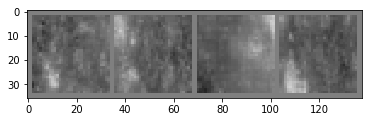

nonpulsar nonpulsar nonpulsar nonpulsar


In [13]:
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Define a neural network that takes 3-channel images as input:

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [15]:
net = Net()

We'll use Classification Cross-Entropy loss and SGD with momentum for optimization:

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Run a few epochs of training:

In [17]:
nepoch = 2  # number of epochs

for epoch in range(nepoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.205
[1,  4000] loss: 0.087
[1,  6000] loss: 0.046
[1,  8000] loss: 0.038
[1, 10000] loss: 0.040
[1, 12000] loss: 0.038
[2,  2000] loss: 0.030
[2,  4000] loss: 0.026
[2,  6000] loss: 0.030
[2,  8000] loss: 0.032
[2, 10000] loss: 0.030
[2, 12000] loss: 0.028
Finished Training


Now we'll try out a couple of test samples just for visual kicks. First load them up and take a look at the true labels:

In [18]:
dataiter = iter(testloader)
images, labels = dataiter.next()

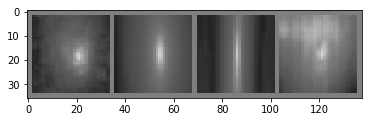

GroundTruth:  pulsar pulsar pulsar pulsar


In [19]:
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Then see what the network predicts that they are:

In [20]:
outputs = net(images)

In [21]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:  pulsar pulsar pulsar nonpulsar


Now calculate the overall accuracy of the network on **all** the test images:

In [22]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 98 %


This is a seriously imbalanced dataset, so let's take a look at the accuracy for individual classes:

In [23]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

In [24]:
for i in range(2):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of pulsar : 78 %
Accuracy of nonpulsar : 99 %
